In [1]:
### lab 7 and 8
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats
import pickle
import math
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (12,7.5)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [2]:
# import LHC data set 2:
higgs_file_in = open('higgs_100000_pt_1000_1200.pkl', 'rb')
higgs_data = pickle.load(higgs_file_in) # pandas DataFrame
print(type(higgs_data))
keys = higgs_data.keys()
print(keys)
qcd_file_in = open('qcd_100000_pt_1000_1200.pkl', 'rb')
qcd_data = pickle.load(qcd_file_in) # pandas DataFrame

<class 'pandas.core.frame.DataFrame'>
Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')


## Lab 7. 
Event selection optimization You and your lab partner should pick different pT (transverse momentum) samples for this lab. In each pT sample, there are dedicated training samples for event selection optimization. All studies should be carried out by normalizing Higgs and QCD samples in each pT sample to give expected yields accordingly (See Dataset descriptions).

#### 1. Make a stacked histogram plot for the feature variable: mass
* Evaluate expected significance without any event selection.
    * Use Poisson statistics for significance calculation

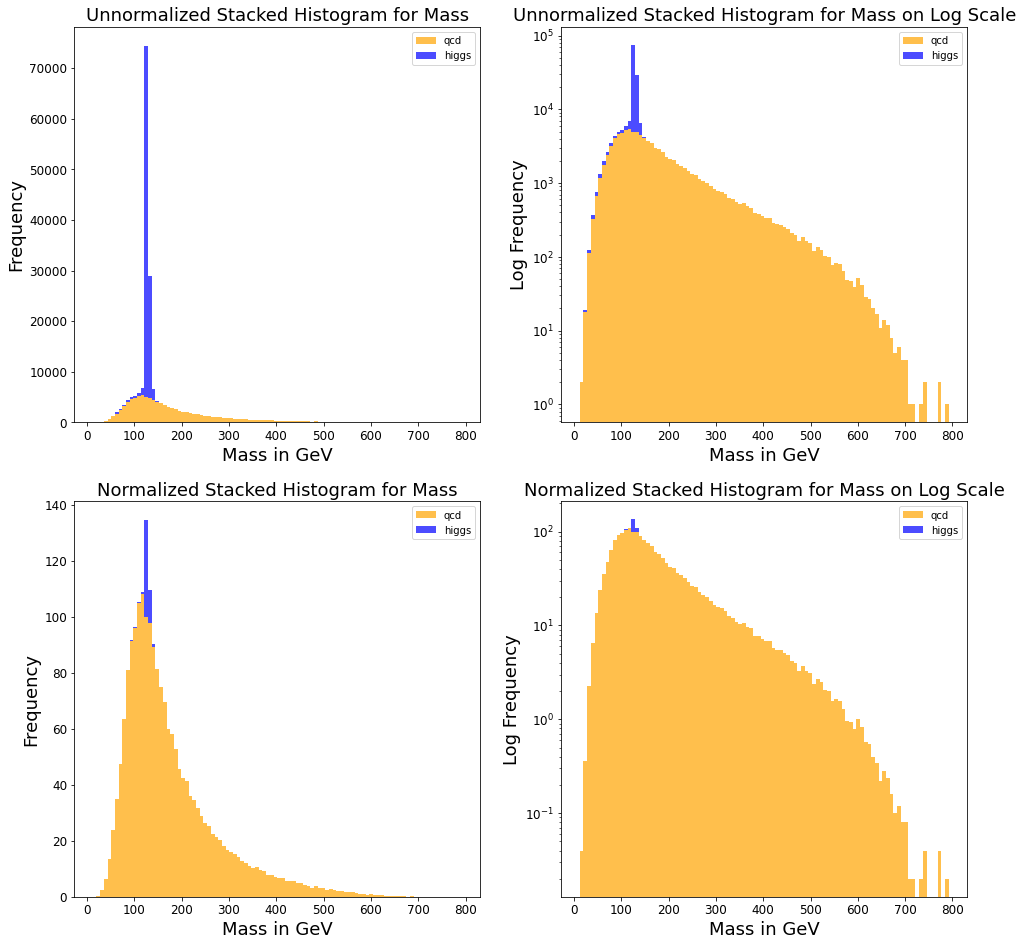

In [3]:
# stacked histogram plot for mass
# expected value of QCD: N_qcd = 2000
# expected value of higgs: N_higgs = 50
# the data has a hundred thousand data points for both background and higgs, but in reality, there are much fewer higgs than background points, so we 
# manipulate the counts on the histogram by adjusting the weight of each data point in the higgs data set to the ratio 50/2000 or 0.025
# Note: setting density=True will not let you see the effect of the weight because density=True will cause the shape of the graph
# to still stay at total probability = 1
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

key = 'mass'
ax[0][0].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), label=('qcd', 'higgs'), alpha=0.7, stacked=True)
ax[0][0].legend()
ax[0][0].set_title("Unnormalized Stacked Histogram for Mass", fontsize=18)
ax[0][0].set_xlabel('Mass in GeV', fontsize=18)
ax[0][0].set_ylabel('Frequency', fontsize=18)

ax[0][1].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), label=('qcd', 'higgs'), alpha=0.7, stacked=True)
ax[0][1].legend()
ax[0][1].set_title("Unnormalized Stacked Histogram for Mass on Log Scale", fontsize=18)
ax[0][1].set_xlabel('Mass in GeV', fontsize=18)
ax[0][1].set_ylabel('Log Frequency', fontsize=18)
ax[0][1].set_yscale('log')

hist_weights_qcd = np.ones(int(1e5)) * 2000/100000
hist_weights_higgs = np.ones(int(1e5)) * 50/100000
ax[1][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.7, stacked=True)
ax[1][0].legend()
ax[1][0].set_title("Normalized Stacked Histogram for Mass", fontsize=18)
ax[1][0].set_xlabel('Mass in GeV', fontsize=18)
ax[1][0].set_ylabel('Frequency', fontsize=18)

ax[1][1].hist((qcd_data[key], higgs_data[key]), bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=(hist_weights_qcd, hist_weights_higgs), alpha=0.7, stacked=True)
ax[1][1].legend()
ax[1][1].set_title("Normalized Stacked Histogram for Mass on Log Scale", fontsize=18)
ax[1][1].set_xlabel('Mass in GeV', fontsize=18)
ax[1][1].set_ylabel('Log Frequency', fontsize=18)
ax[1][1].set_yscale('log')

In [4]:
# evaluation of expected significance
# Given that the background (QCD) is Poisson distributed with mu=2000, what is the probability of the background producing a 
# signal with >= 2050 events (2050 is the sum of the two expected values)? (significance is in terms of sigma on the normal distribution)
sig_2050 = abs(stats.norm.ppf(1 - stats.poisson.cdf(2050, mu=2000)))
print("Expected Significance = " + str(sig_2050))
print("Approximate Theoretical Significance = " + str(50/math.sqrt(2000)))

Expected Significance = 1.1282230087754428
Approximate Theoretical Significance = 1.118033988749895


#### 1. (continued)
* Compare the exact significance to the approximation  N_higgs/(√N_qcd). If they are equivalent, explain your findings.

The calculated or expected significance of the background producing the candidate signal of 2050 events is pretty close to the approximation. This is because of the relationship between Poisson distribution with high mean and the Gausssian distribution. At high mean, the Poisson distribution strongly resembles the standard normal distribution, so we can take advantage of the parameters and properties of both to arrive at this mathematical approximation. The z-score on the standard normal distribution, which is equivalent to the sigma value, has the formula (X - μ)/σ, where X is some value, μ is the expected value, and σ is the standard deviation. A Poisson distribution as expected value of μ and a standard deviation or spread of √μ. We are testing the probability of getting our candidate signal or something higher on the background QCD distribution that has expected value of μ = N_qcd. Let our candidate signal of 2050 be N_total. N_total = N_higgs + N_qcd, so N_higgs = N_total - N_qcd. Borrowing the formula for Z score on the Gaussian distribution, N_total = X (some value), N_qcd is our expected value μ, while σ for Poisson is √μ which is √N_qcd. Therefore, because Poisson with high expected value resembles a Gaussian distribution, N_higgs/(√N_qcd) is a good approximation for sigma.

#### 2. Identify mass cuts to optimize the expected significance.
* Try different mass cuts systematically
* Evaluate expected significance for each set of mass cuts
* Identify the set of mass cuts which give you the highest significance.

In [5]:
qcd_mass = qcd_data['mass']
higgs_mass = higgs_data['mass']
min_higgs_mass = min(higgs_mass)
max_higgs_mass = max(higgs_mass)
print('Min Higgs Mass: ' + str(min_higgs_mass))
print('Max Higgs Mass: ' + str(max_higgs_mass))
max_cut = 0
max_sig = 0
cut_width = 5
max_higgs_cut = 0
max_qcd_cut = 0

i = int(min_higgs_mass)
while i < math.ceil(max_higgs_mass):
    higgs_cut = higgs_mass[(higgs_mass > (i-cut_width)) & (higgs_mass <= i)]
    qcd_cut = qcd_mass[(qcd_mass > (i-cut_width)) & (qcd_mass <= i)]
    sig = (len(higgs_cut) * (50/int(1e5))) / math.sqrt(len(qcd_cut) * (2000/int(1e5)))
    if sig > max_sig:
        max_sig = sig
        max_cut = i
        max_higgs_cut = higgs_cut
        max_qcd_cut = qcd_cut
    i = i + 0.05
print('Highest Expected Significance: ' + str(max_sig))
print('Cut range with highest significance: ' + str(max_cut-cut_width) + ' to ' + str(max_cut))

Min Higgs Mass: 22.77489027858491
Max Higgs Mass: 154.6136749993263
Highest Expected Significance: 4.479846570589385
Cut range with highest significance: 124.8499999999951 to 129.8499999999951


A cut width of 5 is the smallest cut that is recommended, so I applied the a window of width 5 to the range of mass values that the higgs data covers, while moving the window of 5 at increments of 0.05, and found that the set of mass cuts with the highest significance is 124.85 to 129.85.

#### 3. Make two sets of stacked histogram plots for the rest of the features
* Set A without any event selection
    * Can you identify another feature as discriminative as mass? (i.e. equal or better significance after feature cut)
* Set B with your optimal mass cuts
    * Can you identify another feature to further improve your expected signifiance?

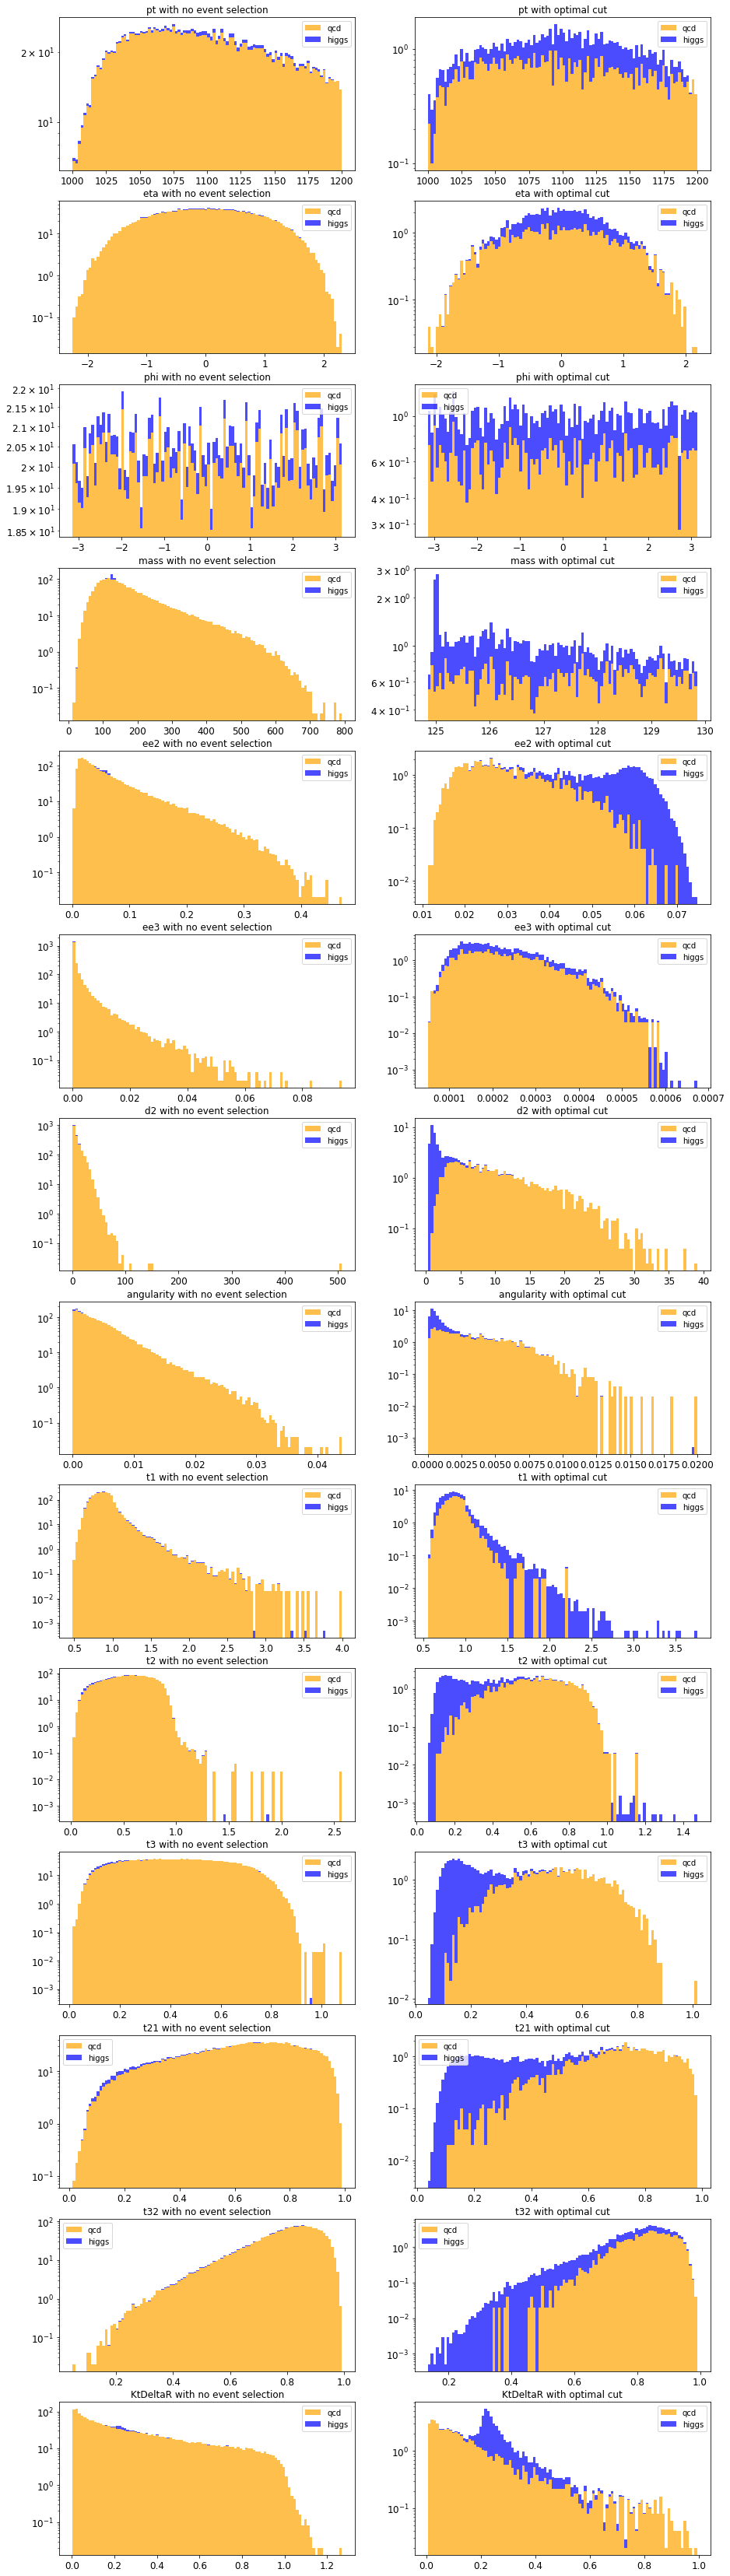

In [6]:
fig, ax = plt.subplots(14, 2, figsize=(15, 60))

qcd_cut_indices = max_qcd_cut.index
higgs_cut_indices = max_higgs_cut.index

i = 0
hist_weights_qcd = np.ones(int(1e5)) * 2000/100000
hist_weights_higgs = np.ones(int(1e5)) * 50/100000
for key in keys:
    ax[i][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.7, stacked=True)
    ax[i][0].legend()
    ax[i][0].set_title(key + ' with no event selection')
    ax[i][0].set_yscale('log')
    
    ax[i][1].hist([qcd_data[key][qcd_cut_indices], higgs_data[key][higgs_cut_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd[qcd_cut_indices], hist_weights_higgs[higgs_cut_indices]], alpha=0.7, stacked=True)
    ax[i][1].legend()
    ax[i][1].set_title(key + ' with optimal cut')
    ax[i][1].set_yscale('log')
    
    i = i + 1

Before cutting the data by mass, there do seem to be a few other features where there is a high concentration of higgs data, and therefore can potentially be used for further event selection. After applying the optimal mass cut, it seems that KtDeltaR is a good candidate for further event selection since there is a distict peak in the higgs data to use to further improve the overall pt significance.

#### 4. Optimize event selections using multiple features (if necessary)
* Find a set of feature cuts which achieve high expected significance.
* Compare significance (before/after event selection) derived in your pT samples to your lab partner. Describe your findings.

In [7]:
print('Approximate significance N_higgs/(√N_qcd) before event selection: ' + str(50/math.sqrt(2000)))
print('Approximate significance after event selection by mass: ' 
      + str((higgs_cut_indices.size * 50/int(1e5)) / math.sqrt(qcd_cut_indices.size * 2000/int(1e5))))

# apply second cut to data after cut by mass
cut_width_kt = 0.1
kt_max_sig = 0
max_higgs_ktcut = 0
max_qcd_ktcut = 0
i = cut_width_kt
max_sig = 0
max_cut_kt = 0
key = 'KtDeltaR'

# apply second cut
higgs_1cut_qtdata = higgs_data[key][higgs_cut_indices]
qcd_1cut_qtdata = qcd_data[key][qcd_cut_indices]
while i < 1:
    higgs_cut = higgs_1cut_qtdata[(higgs_1cut_qtdata > (i-cut_width_kt)) & (higgs_1cut_qtdata < i)]
    qcd_cut = qcd_1cut_qtdata[(qcd_1cut_qtdata > (i-cut_width_kt)) & (qcd_1cut_qtdata < i)]
    sig = (higgs_cut.size * 50/int(1e5)) / math.sqrt(qcd_cut.size * 2000/int(1e5))
    if sig > max_sig:
        max_sig = sig
        max_cut_kt = i
        max_higgs_ktcut = higgs_cut
        max_qcd_ktcut = qcd_cut
    i = i + 0.01

print('Cut Width for KtDeltaR: ' + str(cut_width_kt))
print('Highest Signficance range for KtDeltaR: ' + str(round(max_cut_kt-cut_width_kt, 3)) + ' to ' + str(round(max_cut_kt, 3)))
print('Approximate significance after event selection by KtDeltaR: ' + str(max_sig))
print('Percent of Higgs Data left after both cuts: ' + str(max_higgs_ktcut.size/int(1e5)))

Approximate significance N_higgs/(√N_qcd) before event selection: 1.118033988749895
Approximate significance after event selection by mass: 4.479846570589385
Cut Width for KtDeltaR: 0.1
Highest Signficance range for KtDeltaR: 0.2 to 0.3
Approximate significance after event selection by KtDeltaR: 8.44153229108896
Percent of Higgs Data left after both cuts: 0.48581


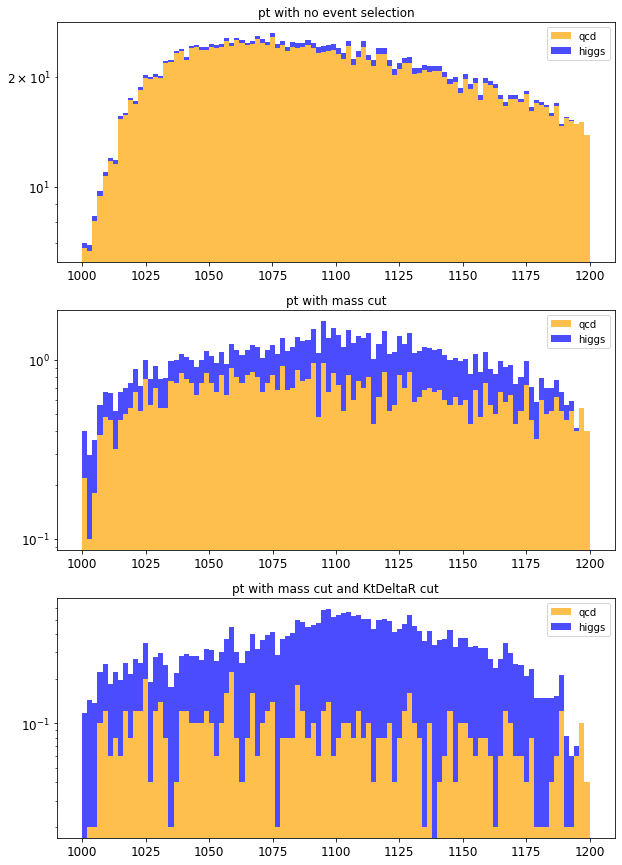

In [8]:
# plot pt with no event selection, 1 cut by mass, 2 cuts by mass and KtDeltaR
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

key = 'pt'
hist_weights_qcd = np.ones(int(1e5)) * 2000/int(1e5)
hist_weights_higgs = np.ones(int(1e5)) * 50/int(1e5)

ax[0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.7, stacked=True)
ax[0].legend()
ax[0].set_title(key + ' with no event selection')
ax[0].set_yscale('log')

ax[1].hist([qcd_data[key][qcd_cut_indices], higgs_data[key][higgs_cut_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd[qcd_cut_indices], hist_weights_higgs[higgs_cut_indices]], alpha=0.7, stacked=True)
ax[1].legend()
ax[1].set_title(key + ' with mass cut')
ax[1].set_yscale('log')

qcd_cut2_indices = max_qcd_ktcut.index
higgs_cut2_indices = max_higgs_ktcut.index
ax[2].hist([qcd_data[key][qcd_cut2_indices], higgs_data[key][higgs_cut2_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd[qcd_cut2_indices], hist_weights_higgs[higgs_cut2_indices]], alpha=0.7, stacked=True)
ax[2].legend()
ax[2].set_title(key + ' with mass cut and KtDeltaR cut')
ax[2].set_yscale('log')

#### 4. (continued)
After plotting all the features after doing event selection through the mass feature, I decided to use KtDeltaR for the second cut. My significance before and after these rounds of event selection mirrored those of my partner. He used the low PT data, whereas I used the high PT data. My significance started at around 1.11 sigma without event selection, increased to 4.47 sigma after cutting the data by mass, then finally to 8.24 sigma after doing event selection a second time by KtDeltaR. Similarly, my partner started at around 0.78 sigma without event selection, improving to 4.98 sigma after the event selection by mass, then finally to 6.30 after doing a final round of event selection. These findings make sense as we improve the significance by selecting ranges of data to improve the ratio of signal to background, thus improving the overall significance.

## Lab 8. 
Pseudo-experiment data analysis Using your optimized event selection, hunt for your signal by using the pseduo-experiment datasets.

In [9]:
# import high luminosity and low luminosity data
high_lum_file = h5py.File('data_highLumi_pt_1000_1200.h5', 'r')
print(high_lum_file.keys())
highlumi_data_unfiltered = high_lum_file['data']

low_lum_file = h5py.File('data_lowLumi_pt_1000_1200.h5', 'r')
print(low_lum_file.keys())
lowlumi_data_unfiltered = low_lum_file['data']

lumi_keys = np.array(highlumi_data_unfiltered['block0_items'])
print(keys)
highlumi_data = pd.DataFrame(highlumi_data_unfiltered['block0_values'], columns=highlumi_data_unfiltered['block0_items'])
lowlumi_data = pd.DataFrame(lowlumi_data_unfiltered['block0_values'], columns=lowlumi_data_unfiltered['block0_items'])
print('High Lumosity Data Shape: ' + str(highlumi_data.shape))
print('Low Lumosity Data Shape: ' + str(lowlumi_data.shape))

highlumi_size = highlumi_data.shape[0]
lowlumi_size = lowlumi_data.shape[0]

print('High Luminosity Size: ' + str(highlumi_size))
print('Low Luminosity Size: ' + str(lowlumi_size))
print('Sample key: ' + str(lumi_keys[3]))

high_lum_file.close()
low_lum_file.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['data']>
Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
High Lumosity Data Shape: (4066, 14)
Low Lumosity Data Shape: (442, 14)
High Luminosity Size: 4066
Low Luminosity Size: 442
Sample key: b'mass'


#### 1. High luminosity data
* For each feature of your event selection, plot the observed data overlapped with expected signal and background (normalized to observed yields) with/without event selection.
* Evaluate observed significance and compare your results to expectation.

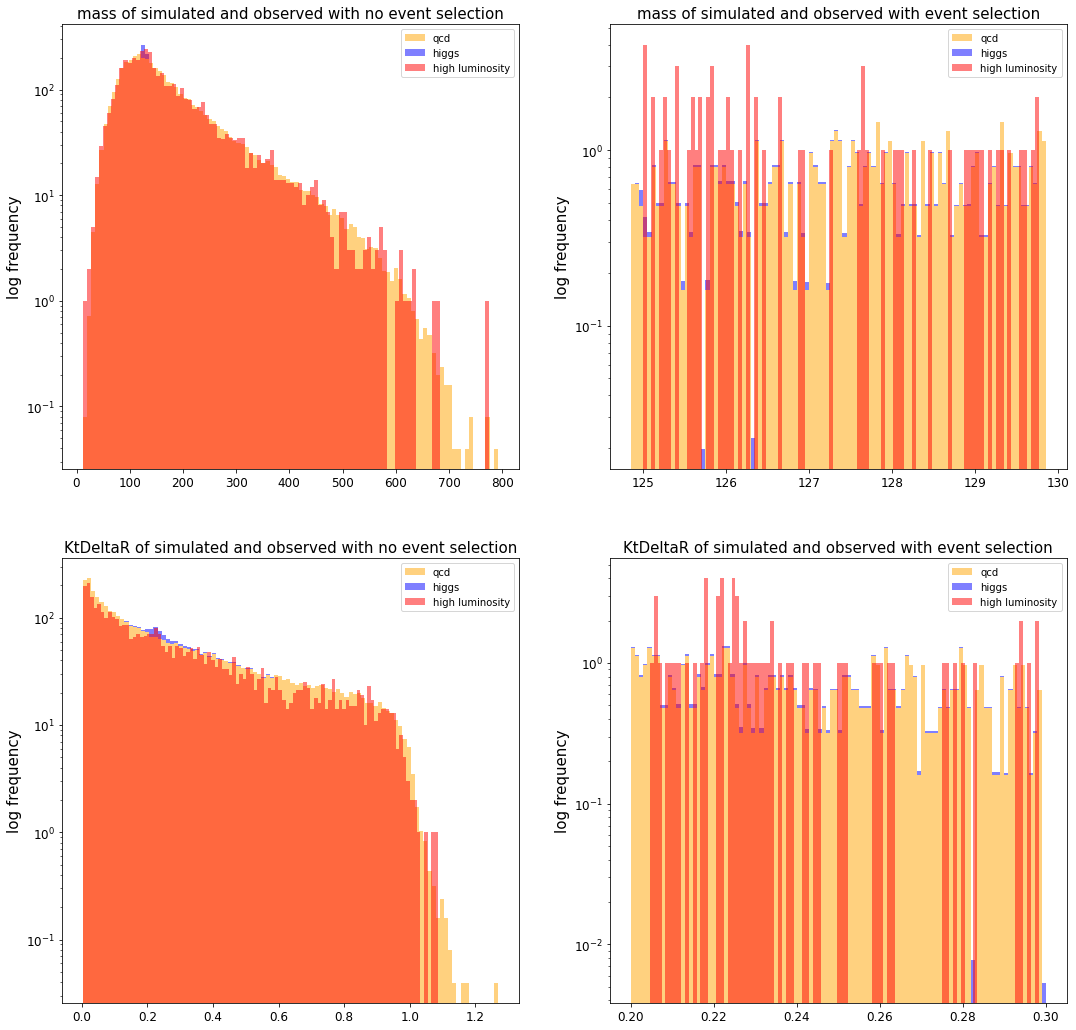

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))

# mass graphs
# mass no event selection graph
key = 'mass'
mass_key = lumi_keys[3] # mass for observed data
num_data = int(1e5)
hist_weights_qcd = np.ones(int(1e5)) * ((2000/2050) / num_data * highlumi_size)
hist_weights_higgs = np.ones(int(1e5)) * ((50/2050) / num_data * highlumi_size)

ax[0][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[0][0].hist(highlumi_data[mass_key], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[0][0].legend()
ax[0][0].set_title(key + ' of simulated and observed with no event selection', fontsize=15)
ax[0][0].set_ylabel('log frequency', fontsize=15)
ax[0][0].set_yscale('log')

# mass after event selection graph
qcd_cut2_indices = max_qcd_ktcut.index
higgs_cut2_indices = max_higgs_ktcut.index

# apply both mass and KtDeltaR cuts to the high luminosity data
kt_key = lumi_keys[13] # KtDeltaR of observed data key
highlumi_mass = highlumi_data[mass_key]
highlumi_filter_mass = highlumi_mass[(highlumi_mass > (max_cut - cut_width)) & (highlumi_mass < (max_cut))]
highlumi_filter_indices = np.array(highlumi_filter_mass.index)
highlumi_kt_masscut = highlumi_data[kt_key][highlumi_filter_indices]
highlumi_filter_kt = highlumi_kt_masscut[(highlumi_kt_masscut > (max_cut_kt - cut_width_kt)) \
                                               & (highlumi_kt_masscut < max_cut_kt)]
highlumi_final_indices = np.array(highlumi_filter_kt.index)

# weights with normalization
hist_weights_qcd = np.ones(qcd_cut2_indices.size) * ((2000/2050) / qcd_cut2_indices.size * highlumi_final_indices.size)
hist_weights_higgs = np.ones(higgs_cut2_indices.size) * ((50/2050) / higgs_cut2_indices.size * highlumi_final_indices.size)

ax[0][1].hist([qcd_data[key][qcd_cut2_indices], higgs_data[key][higgs_cut2_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[0][1].hist(highlumi_data[mass_key][highlumi_final_indices], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[0][1].legend()
ax[0][1].set_title(key + ' of simulated and observed with event selection', fontsize=15)
ax[0][1].set_ylabel('log frequency', fontsize=15)
ax[0][1].set_yscale('log')

# KtDeltaR graphs
# KtDeltaR with no event selection
hist_weights_qcd = np.ones(int(1e5)) * ((2000/2050) / num_data * highlumi_size)
hist_weights_higgs = np.ones(int(1e5)) * ((50/2050) / num_data * highlumi_size)
key = 'KtDeltaR'
ax[1][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[1][0].hist(highlumi_data[kt_key], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[1][0].legend()
ax[1][0].set_title(key + ' of simulated and observed with no event selection', fontsize=15)
ax[1][0].set_ylabel('log frequency', fontsize=15)
ax[1][0].set_yscale('log')

# KtDeltaR with event selection
hist_weights_qcd = np.ones(qcd_cut2_indices.size) * ((2000/2050) / qcd_cut2_indices.size * highlumi_final_indices.size)
hist_weights_higgs = np.ones(higgs_cut2_indices.size) * ((50/2050) / higgs_cut2_indices.size * highlumi_final_indices.size)
ax[1][1].hist([qcd_data[key][qcd_cut2_indices], higgs_data[key][higgs_cut2_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[1][1].hist(highlumi_data[kt_key][highlumi_final_indices], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[1][1].legend()
ax[1][1].set_title(key + ' of simulated and observed with event selection', fontsize=15)
ax[1][1].set_ylabel('log frequency', fontsize=15)
ax[1][1].set_yscale('log')

In [11]:
print('Background left out of 100,000 events after two cuts: ' + str(qcd_cut2_indices.size))
print('Proportion background after cuts: ' + str(qcd_cut2_indices.size/int(1e5)))
expected_value = qcd_cut2_indices.size/int(1e5) * highlumi_size
print('Expected number of events in background assuming no signal (null hypothesis): ' + str(expected_value))
events = highlumi_final_indices.size
print('Events left in observed data after two cuts: ' + str(events))
sig = stats.norm.ppf(stats.poisson.cdf(k=events, mu=expected_value))
print('Significance of ' + str(events) + ' events on a Poisson distribution with expected value ' + str(expected_value) + ': ' + str(sig))

Background left out of 100,000 events after two cuts: 414
Proportion background after cuts: 0.00414
Expected number of events in background assuming no signal (null hypothesis): 16.83324
Events left in observed data after two cuts: 68
Significance of 68 events on a Poisson distribution with expected value 16.83324: inf


The significance of events is too large to actually calculate here. According to my cuts, the proportion of background events that should have been left after two cuts follows a Poisson distribution with an expected value of about 16.8. However, the number of events that were left in the observed data after performing the same two cuts as the ones I used on the simulated data was 68, much higher than the expected value.

#### 2. Low luminosity data
* Do as before with the high luminosity data and comment on the difference.

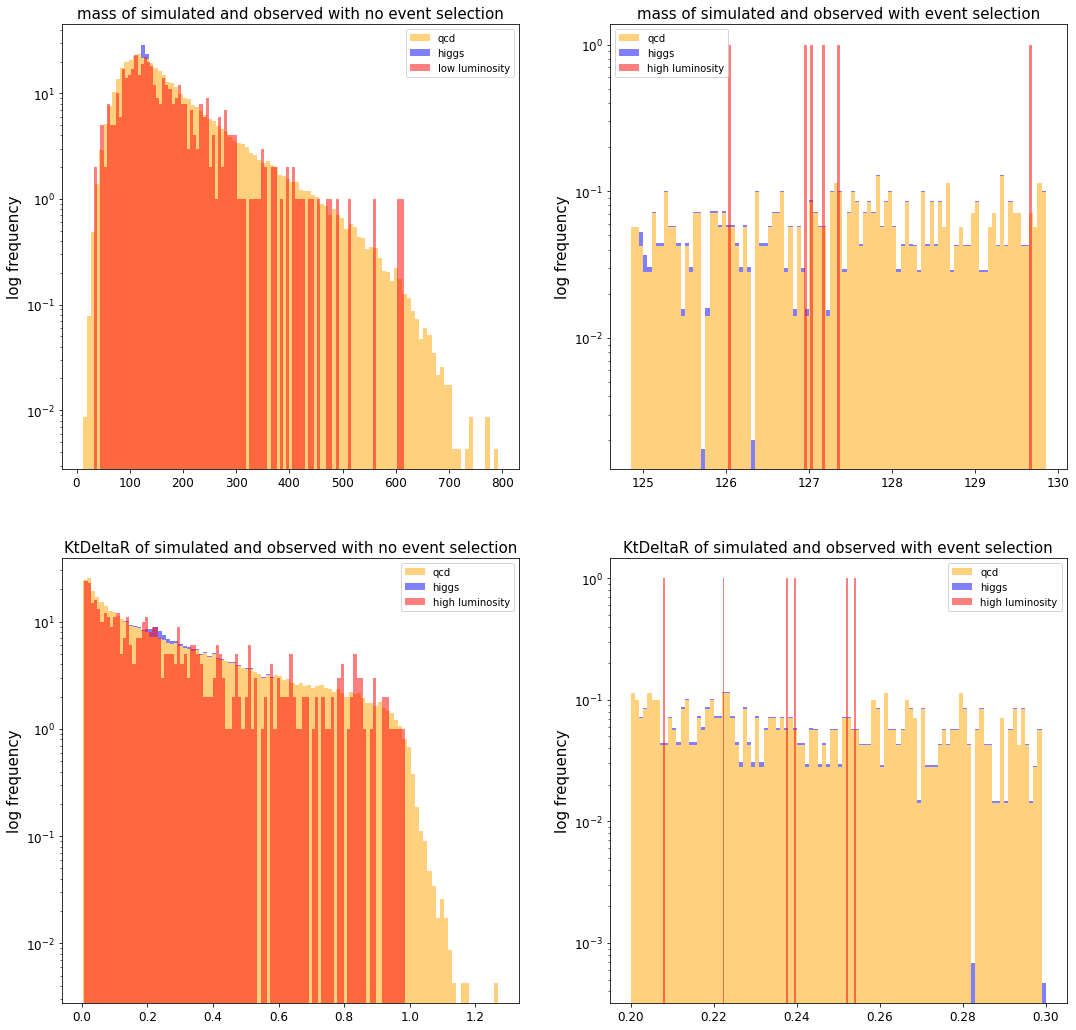

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(18, 18))

# mass graphs
# mass no event selection graph
key = 'mass'
mass_key = lumi_keys[3] # mass for observed data
num_data = int(1e5)
hist_weights_qcd = np.ones(int(1e5)) * ((2000/2050) / num_data * lowlumi_size)
hist_weights_higgs = np.ones(int(1e5)) * ((50/2050) / num_data * lowlumi_size)

ax[0][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[0][0].hist(lowlumi_data[mass_key], bins=100, color=('red'), label=('low luminosity'), alpha = 0.5)
ax[0][0].legend()
ax[0][0].set_title(key + ' of simulated and observed with no event selection', fontsize=15)
ax[0][0].set_ylabel('log frequency', fontsize=15)
ax[0][0].set_yscale('log')

# mass after event selection graph
qcd_cut2_indices = max_qcd_ktcut.index
higgs_cut2_indices = max_higgs_ktcut.index

# apply both mass and KtDeltaR cuts to the low luminosity data
kt_key = lumi_keys[13] # KtDeltaR of observed data key
lowlumi_mass = lowlumi_data[mass_key]
lowlumi_filter_mass = lowlumi_mass[(lowlumi_mass > (max_cut - cut_width)) & (lowlumi_mass < (max_cut))]
lowlumi_filter_indices = np.array(lowlumi_filter_mass.index)
lowlumi_kt_masscut = lowlumi_data[kt_key][lowlumi_filter_indices]
lowlumi_filter_kt = lowlumi_kt_masscut[(lowlumi_kt_masscut > (max_cut_kt - cut_width_kt)) \
                                               & (lowlumi_kt_masscut < max_cut_kt)]
lowlumi_final_indices = np.array(lowlumi_filter_kt.index)

# weights with normalization
hist_weights_qcd = np.ones(qcd_cut2_indices.size) * ((2000/2050) / qcd_cut2_indices.size * lowlumi_final_indices.size)
hist_weights_higgs = np.ones(higgs_cut2_indices.size) * ((50/2050) / higgs_cut2_indices.size * lowlumi_final_indices.size)

ax[0][1].hist([qcd_data[key][qcd_cut2_indices], higgs_data[key][higgs_cut2_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[0][1].hist(lowlumi_data[mass_key][lowlumi_final_indices], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[0][1].legend()
ax[0][1].set_title(key + ' of simulated and observed with event selection', fontsize=15)
ax[0][1].set_ylabel('log frequency', fontsize=15)
ax[0][1].set_yscale('log')

# KtDeltaR graphs
# KtDeltaR with no event selection
hist_weights_qcd = np.ones(int(1e5)) * ((2000/2050) / num_data * lowlumi_size)
hist_weights_higgs = np.ones(int(1e5)) * ((50/2050) / num_data * lowlumi_size)
key = 'KtDeltaR'
ax[1][0].hist([qcd_data[key], higgs_data[key]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[1][0].hist(lowlumi_data[kt_key], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[1][0].legend()
ax[1][0].set_title(key + ' of simulated and observed with no event selection', fontsize=15)
ax[1][0].set_ylabel('log frequency', fontsize=15)
ax[1][0].set_yscale('log')

# KtDeltaR with event selection
hist_weights_qcd = np.ones(qcd_cut2_indices.size) * ((2000/2050) / qcd_cut2_indices.size * lowlumi_final_indices.size)
hist_weights_higgs = np.ones(higgs_cut2_indices.size) * ((50/2050) / higgs_cut2_indices.size * lowlumi_final_indices.size)
ax[1][1].hist([qcd_data[key][qcd_cut2_indices], higgs_data[key][higgs_cut2_indices]], bins=100, color=('orange', 'blue'), 
              label=('qcd', 'higgs'), weights=[hist_weights_qcd, hist_weights_higgs], alpha=0.5, stacked=True)
ax[1][1].hist(lowlumi_data[kt_key][lowlumi_final_indices], bins=100, color=('red'), label=('high luminosity'), alpha = 0.5)
ax[1][1].legend()
ax[1][1].set_title(key + ' of simulated and observed with event selection', fontsize=15)
ax[1][1].set_ylabel('log frequency', fontsize=15)
ax[1][1].set_yscale('log')

In [13]:
print('Background left out of 100,000 events after two cuts: ' + str(qcd_cut2_indices.size))
print('Proportion background after cuts: ' + str(qcd_cut2_indices.size/int(1e5)))
expected_value = qcd_cut2_indices.size/int(1e5) * lowlumi_size
print('Expected number of events in background assuming no signal (null hypothesis): ' + str(expected_value))
events = lowlumi_final_indices.size
print('Events left in observed data after two cuts: ' + str(events))
sig = stats.norm.ppf(stats.poisson.cdf(k=events, mu=expected_value))
print('Significance of ' + str(events) + ' events on a Poisson distribution with expected value ' + str(expected_value) + ': ' + str(sig))

Background left out of 100,000 events after two cuts: 414
Proportion background after cuts: 0.00414
Expected number of events in background assuming no signal (null hypothesis): 1.8298799999999997
Events left in observed data after two cuts: 6
Significance of 6 events on a Poisson distribution with expected value 1.8298799999999997: 2.7690466829420233


Compared to the high luminosity data where the signficance went to infinity, the low luminosity data had a much more reasonable Poisson distribution for expected value. Although the number of expected background events becomes very low which can be worrisome in some cases - perhaps we are filtering out too much background - in this case it makes some sense since the number of events is very low to begin with.

#### 3. 95% Confidence Level of signal yields
* In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level upper limit of signal yield.
* Evaluate the expected 95% confidence level upper limit
* Evaluate the observed 95% confidence level upper limit
* Compare expectation to observation. Comment on your finding.

In [14]:
print('Expected 95% confidence level upper limit: ' + str(stats.poisson.ppf(0.95, mu=expected_value)))
print('Observed 95% confidence level upper limit: ' + str(stats.poisson.ppf(0.95, mu=6)))

Expected 95% confidence level upper limit: 4.0
Observed 95% confidence level upper limit: 10.0


We can observe that the observed confidence interval is greater than and includes the expected confidence interval. Thus, we can say with 95% confidence that if we were to conduct the same experiment again, the true expected value would be under 10 events 95% of the time.